In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

from models.utils import detector_head, descriptor_head, detector_loss, descriptor_loss, model_metrics, box_nms
from utils.tools import dict_update

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)

In [7]:
default_config = {
        'labels': None,
        'segmasks': None,
        'cache_in_memory': False,
        'validation_size': 100,
        'truncate': None,
        'preprocessing': {
            'resize': [240, 320]
        },
        'num_parallel_calls': 10,
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': False,
                'params': {},
                'valid_border_margin': 0,
            },
        },
        'warped_pair': {
            'enable': False,
            'params': {},
            'valid_border_margin': 0,
        },
    }

In [8]:
import yaml
with open('/root/Internship-Valeo/Project/configs/superpoint_coco.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [9]:
config1 = config
config = dict_update(default_config, config['data'])

In [10]:
default_model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
            'batch_size': 32,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0,
    }

In [11]:
model_config = dict_update(default_model_config, config1['model'])

In [12]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
from datasets import coco
data = coco.Coco()
files = data._init_dataset(**config)
train_gen = data._get_data(files, 'training', **config)
val_gen = data._get_data(files, 'validation', **config)

In [14]:
# config['primitives'] = 'all'

In [15]:
# # code for photometric augmentation

# primitives_photo = parse_primitives(config['primitives'], photaug.augmentations)

# prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

# indices = tf.range(len(primitives_photo))
# if config['augmentation']['photometric']['random_order']:
#     indices = tf.random.shuffle(indices)
# def photo_aug_step(i, image):
#     fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
#                 for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
#     image = tf.case(fn_pairs)
#     return i + 1, image

In [16]:
# # read keypoints
# def _read_points(filename):
#     return np.load(filename)['points'].astype(np.float32)

In [17]:
# class DataGen(keras.utils.Sequence):
#     def __init__(self, image_path, point_path, #homography_path, 
#                  seg_mask_path, 
#                  #warped_image_path, warped_point_path, warped_seg_mask_path, 
#                  image_size_x = 320, image_size_y = 240,
#                  is_training = True, batch_size = model_config['batch_size']):
        
#         self.__ids = os.listdir(image_path)
#         self.__image_path = image_path
#         self.__point_path = point_path
# #         self.__homography_path = homography_path
#         self.__seg_mask_path = seg_mask_path
# #         self.__warped_image_path = warped_image_path
# #         self.__warped_point_path = warped_point_path
# #         self.__warped_seg_mask_path = warped_seg_mask_path
#         self.__image_size_x = image_size_x
#         self.__image_size_y = image_size_y
#         self.__batch_size = batch_size
#         self.__is_training = is_training
#         self.on_epoch_end()
        
#     def __getitem__(self, index):
#         images = []
#         points_maps = []
#         points_list = []
        
#         homography_list = []
#         seg_masks = []
        
#         warped_images = []
#         warped_points_maps = []
#         warped_points_list = []
        
#         warped_mask_images = []
#         valid_masks = []
        
#         if (index + 1)*self.__batch_size > len(self.__ids):
#             self.__batch_size = len(self.__ids) - index * self.__batch_size
            
#         file_batch = self.__ids[index * self.__batch_size : (index + 1) * self.__batch_size]
        
#         for id_name in file_batch:
#             img_file = os.path.join(self.__image_path,id_name)
#             image = cv2.imread(img_file, 0)
#             image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
#             image = np.expand_dims(image, axis = 2)
#             image_shape = tf.shape(image)[:2]
#             id_name = id_name.replace('.jpg', '.npz')
#             point_file = os.path.join(self.__point_path,id_name)
#             points = _read_points(point_file)
# #             points = np.round(points).astype(int)
            
#             if self.__is_training:
#                 # add photometric_augmentation
#                 _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
#                                  photo_aug_step, [0, image], parallel_iterations=1)              
                
# #                 # read homography file
# #                 homography_file = os.path.join(self.__homography_path, id_name+'.npy')
# #                 homography = _read_points(homography_file)
#                 homography = sample_homography(image_shape, config['warped_pair']['params'])[0]
                
#                 # read segmentation masks
#                 id_name = id_name.replace('.npz', '.jpg')
#                 mask_img_file = os.path.join(self.__seg_mask_path,id_name)
#                 mask_image = cv2.imread(mask_img_file, -1)
#                 mask_image = cv2.resize(mask_image , (self.__image_size_x , self.__image_size_y))
#                 mask_image = mask_image.reshape((self.__image_size_y , self.__image_size_x , 1))
                
# #                 # read warped image
# #                 warped_img_file = os.path.join(self.__warped_image_path,id_name)
# #                 warped_image = cv2.imread(warped_img_file, 0)        
# #                 warped_image = np.expand_dims(image, axis = 2)
#                 warped_image = H_transform(image, homography, interpolation='BILINEAR')
# #                 # read warped seg mask image
# #                 warped_mask_img_file = os.path.join(self.__warped_seg_mask_path,id_name)
# #                 warped_mask_image = cv2.imread(warped_mask_img_file, -1)
# #                 warped_mask_image = cv2.resize(warped_mask_image , (self.__image_size_x , self.__image_size_y))
# #                 warped_mask_image = warped_mask_image.reshape((self.__image_size_y , self.__image_size_x , 1))
#                 warped_mask_image = H_transform(mask_image, homography, interpolation='BILINEAR')
#                 # compute valid mask
#                 valid_mask = compute_valid_mask(image_shape, homography,
#                                          config['augmentation']['homographic']['valid_border_margin'])
                
# #                 # read warped points
# #                 warped_point_file = os.path.join(self.__warped_point_path,id_name+'.npy')
# #                 warped_points = _read_points(warped_point_file)
#                 warped_points = warp_points(points, homography)
#                 warped_points = filter_points(warped_points, image_shape)
#                 warped_points = np.round(warped_points).astype(int)
    
#                 warped_kp = tf.minimum(warped_points, image_shape-1)
#                 warped_points_map = tf.scatter_nd(warped_kp, tf.ones([tf.shape(warped_kp)[0]], 
#                                                                      dtype=tf.int32), image_shape)
                        
                
                
                
#                 homography_list.append(homography)
#                 mask_image = mask_image / 255
#                 seg_masks.append(mask_image)
#                 warped_image = warped_image / 255.0
#                 warped_images.append(warped_image)
#                 warped_mask_image = warped_mask_image / 255
#                 warped_mask_images.append(warped_mask_image)
#                 valid_masks.append(valid_mask)
#                 warped_points_list.append(warped_points)
#                 warped_points_maps.append(warped_points_map)

#             kp = tf.minimum(points, image_shape-1)
#             points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
#             image = image / 255.0
#             images.append(image)
#             points_maps.append(points_map)
#             points_list.append(points)
            
            
            
#         images = np.array(images)
#         points_maps = np.array(points_maps)
        
#         if self.__is_training:
#             warped_images = np.array(warped_images)
#             warped_points_maps = np.array(warped_points_maps)
#             homography_list = np.array(homography_list)
#             warped_images = np.array(warped_images)
#             seg_masks = np.array(seg_masks)
#             warped_mask_images = np.array(warped_mask_images)
#             valid_masks = np.array(valid_masks)
#             dummy_loss_target = np.zeros(self.__batch_size)
#             return [images, 
#                     points_maps, 
#                     homography_list, 
#                     warped_images, 
#                     valid_masks, 
#                     warped_points_maps],[dummy_loss_target, 
#                                          dummy_loss_target, dummy_loss_target, seg_masks, warped_mask_images]
        
#         else:
#             return images, points_maps   
           
#     def __len__(self):
#         return int(np.ceil(len(self.__ids) / float(self.__batch_size)))
    
#     def on_epoch_end(self):
# #         mydir = os.path.join(os.getcwd(), 'results')
# #         mydir = os.path.join(mydir, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# #         os.makedirs(mydir)
# #         model.save(mydir)
#         pass

In [18]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size,
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [19]:
def shared_encoder(model_config, shape = (240, 320,1)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True, 'activation': tf.nn.relu,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    inputs = Input(shape)
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    pool4 = MaxPooling2D(pool_size, name="block4_pool")(conv8)
    return keras.models.Model(inputs = inputs, outputs = {'pool4':pool4, 'conv8':conv8, 'conv7':conv7, 'conv6':conv6, 
                                                          'conv5':conv5, 'conv4':conv4, 'conv3':conv3, 
                                                          'conv2':conv2, 'conv1':conv1}, name = 'shared_encoder')

In [20]:
# keras.utils.plot_model(shared_encoder(model_config = model_config), show_shapes=True, show_dtype=False, show_layer_names=True,
#     rankdir="TB", expand_nested=True, dpi=96)

In [21]:
def segmentation_head(shape_pool4 = (15, 20, 128), shape_conv8 = (30, 40, 128),
                      shape_conv7 = (30, 40, 128), shape_conv6 = (60, 80, 128),
                      shape_conv5 = (60, 80, 128), shape_conv4 = (120, 160, 64),
                      shape_conv3 = (120, 160, 64), shape_conv2 = (240, 320, 64),
                      shape_conv1 = (240, 320, 64), kernel = 3):
    input_pool4 = Input(shape_pool4)
    input_conv8 = Input(shape_conv8)
    input_conv7 = Input(shape_conv7)
    input_conv6 = Input(shape_conv6)
    input_conv5 = Input(shape_conv5)
    input_conv4 = Input(shape_conv4)
    input_conv3 = Input(shape_conv3)
    input_conv2 = Input(shape_conv2)
    input_conv1 = Input(shape_conv1)
    
    conv9 = Conv2DTranspose(128, (kernel, kernel),strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(input_pool4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = concatenate( [input_conv8 , conv9]  , axis = -1)
    conv10 = Conv2DTranspose(128, (kernel, kernel), 
                              padding="same", kernel_initializer='he_uniform')(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation("relu")(conv10)
    conv10 = concatenate( [input_conv7 , conv10]  , axis = -1)


    conv11 = Conv2DTranspose(128, (kernel, kernel), strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation("relu")(conv11)
    conv11 = concatenate( [input_conv6 , conv11]  , axis = -1)
    
    conv12 = Conv2DTranspose(128, (kernel, kernel),padding="same", kernel_initializer='he_uniform')(conv11)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation("relu")(conv12)
    conv12 = concatenate( [input_conv5 , conv12]  , axis = -1)

    conv13 = Conv2DTranspose(64, (kernel, kernel),strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv12)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation("relu")(conv13)
    conv13 = concatenate( [input_conv4 , conv13]  , axis = -1)
    
    conv14 = Conv2DTranspose(64, (kernel, kernel), padding="same", kernel_initializer='he_uniform')(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation("relu")(conv14)
    conv14 = concatenate( [input_conv3 , conv14]  , axis = -1)


    conv15 = Conv2DTranspose(64, (kernel, kernel), strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv14)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation("relu")(conv15)
    conv15 = concatenate( [input_conv2 , conv15]  , axis = -1)
    
    conv16 = Conv2DTranspose(64, (kernel, kernel), padding="same", kernel_initializer='he_uniform')(conv15)
    conv16 = BatchNormalization()(conv16)
    conv16 = concatenate( [input_conv1 , conv16]  , axis = -1)
    
    conv17 = Conv2DTranspose(1, (1, 1), padding="same", kernel_initializer='he_uniform')(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('sigmoid')(conv17)
#     conv17 = Dense(1)(conv17)
#     output = Activation('softmax')(conv17)
    return keras.models.Model(inputs = {'pool4':input_pool4, 'conv8':input_conv8, 'conv7':input_conv7, 
                                        'conv6':input_conv6, 'conv5':input_conv5, 'conv4':input_conv4, 
                                        'conv3':input_conv3, 'conv2':input_conv2, 'conv1':input_conv1}, 
                              outputs = conv17, name = 'segmentation_head')

In [22]:
# keras.utils.plot_model(segmentation_head(), show_shapes=True, show_dtype=False, show_layer_names=True,
#     rankdir="TB", expand_nested=True, dpi=96)

In [23]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            model_config = model_config)
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred)
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'detector_precision')
        self.add_metric(metrics['recall'], name = 'detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__(name = name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'warped_detector_precision')
        self.add_metric(metrics['recall'], name = 'warped_detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

In [24]:
class SemanticsLossLayer(Layer):
    def __init__(self, name='semantics_loss_layer', trainable=False):
        super(SemanticsLossLayer, self).__init__(name = name)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.accuracy_fn = tf.keras.metrics.BinaryAccuracy()

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1])
        accuracy = self.accuracy_fn(inputs[0], inputs[1])
        self.add_loss(loss)
        self.add_metric(accuracy)
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

In [25]:
class WarpedSemanticsLossLayer(Layer):
    def __init__(self, name='warped_semantics_loss_layer', trainable=False):
        super(WarpedSemanticsLossLayer, self).__init__(name = name)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.accuracy_fn = tf.keras.metrics.BinaryAccuracy()

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1])
        accuracy = self.accuracy_fn(inputs[0], inputs[1])
        self.add_loss(loss)
        self.add_metric(accuracy)
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

In [26]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss'] * self.loss_fn(descriptors = inputs[0], 
                                                          warped_descriptors = inputs[1],
                            homographies = inputs[2], valid_mask = inputs[3], **model_config)
        self.add_loss(loss)
#         return tf.reshape(loss, (1,))
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
def net():
    
#     images_input = Input(shape = (240, 320,1), name = 'images_input')
#     points_list_input = Input(shape = (240, 320), name = 'points_input') 
#     homography_list_input = Input(shape = (8,), name = 'homography_list_input') 
#     warped_images_input = Input(shape = (240, 320,1), name = 'warped_images_input')
#     valid_masks_input = Input(shape = (240, 320), name = 'valid_masks_input')
#     warped_points_list_input = Input(shape = (240, 320), name = 'warped_points_input')
    
    
    inputs = {'image':Input(shape = (240, 320, 1), name = 'image'),
              'name': Input(shape = (None,1), name = 'name'),
              'keypoints':Input(shape = (240,320), name = 'keypoints'),              
              'valid_mask':Input(shape = (240,320), name = 'valid_mask'),
              'mask_image':Input(shape = (240, 320, 1), name = 'mask_image'),
              'warped':{
                  'image':Input(shape = (240, 320, 1), name = 'warped_image'),
                  'name': Input(shape = (None,1), name = 'warped_name'),
                  'keypoints':Input(shape = (240, 320), name = 'warped_keypoints'),
                  'valid_mask':Input(shape = (240, 320), name = 'warped_valid_mask'),
                  'mask_image':Input(shape = (240, 320, 1), name = 'warped_mask_image'),
                  'homography':Input(shape = (8,), name = 'homography'),
               }}
    
    homography_model = HomographyModel()
#     homography = homography_model(homography_list_input)
    homography = homography_model(inputs['warped']['homography'])
    
    encoder = shared_encoder(model_config = model_config)
#     encoder_output = encoder(images_input)
#     warped_encoder_output = encoder(warped_images_input)
    encoder_output = encoder(inputs['image'])
    warped_encoder_output = encoder(inputs['warped']['image'])
    
    detector = detector_head(shape = (30, 40, 128), model_config = model_config)
    detector_output = detector(encoder_output['conv7'])
    warped_detector_output = detector(warped_encoder_output['conv7'])
    
    descriptor = descriptor_head(shape = (30, 40, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output['conv7'])
    warped_descriptor_output = descriptor(warped_encoder_output['conv7'])
    
    semantics_model = segmentation_head()
    semantics_output = semantics_model(encoder_output)
    warped_semantics_output = semantics_model(warped_encoder_output)
    
#     detector_loss_layer = DetectorLossLayer()([points_list_input, detector_output])
    detector_loss_layer = DetectorLossLayer()([inputs['keypoints'],
                                                 detector_output])
    
#     warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_list_input, 
#                                                 warped_detector_output, 
#                                                       valid_masks_input])

    warped_detector_loss_layer = WarpedDetectorLossLayer()([inputs['warped']['keypoints'], 
                                                warped_detector_output, 
                                                      inputs['warped']['valid_mask']])
    
#     descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
#                                         warped_descriptor_output['descriptors_raw'], 
#                                           homography, valid_masks_input])

    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
                                                   warped_descriptor_output['descriptors_raw'], 
                                          inputs['warped']['homography'], inputs['warped']['valid_mask']])
    
    semantics_loss_layer = SemanticsLossLayer()([inputs['mask_image'], semantics_output])
    
    warped_semantics_loss_layer = WarpedSemanticsLossLayer()([inputs['warped']['mask_image'], 
                                                        tf.expand_dims(inputs['warped']['valid_mask'], 
                                                                       axis = 2)*warped_semantics_output])
    
    model = keras.models.Model(inputs = inputs,#[images_input, points_list_input, homography_list_input, 
                                         #warped_images_input, valid_masks_input, warped_points_list_input],
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer, semantics_loss_layer, 
                                          warped_semantics_loss_layer])
    return model

In [27]:
model = net()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


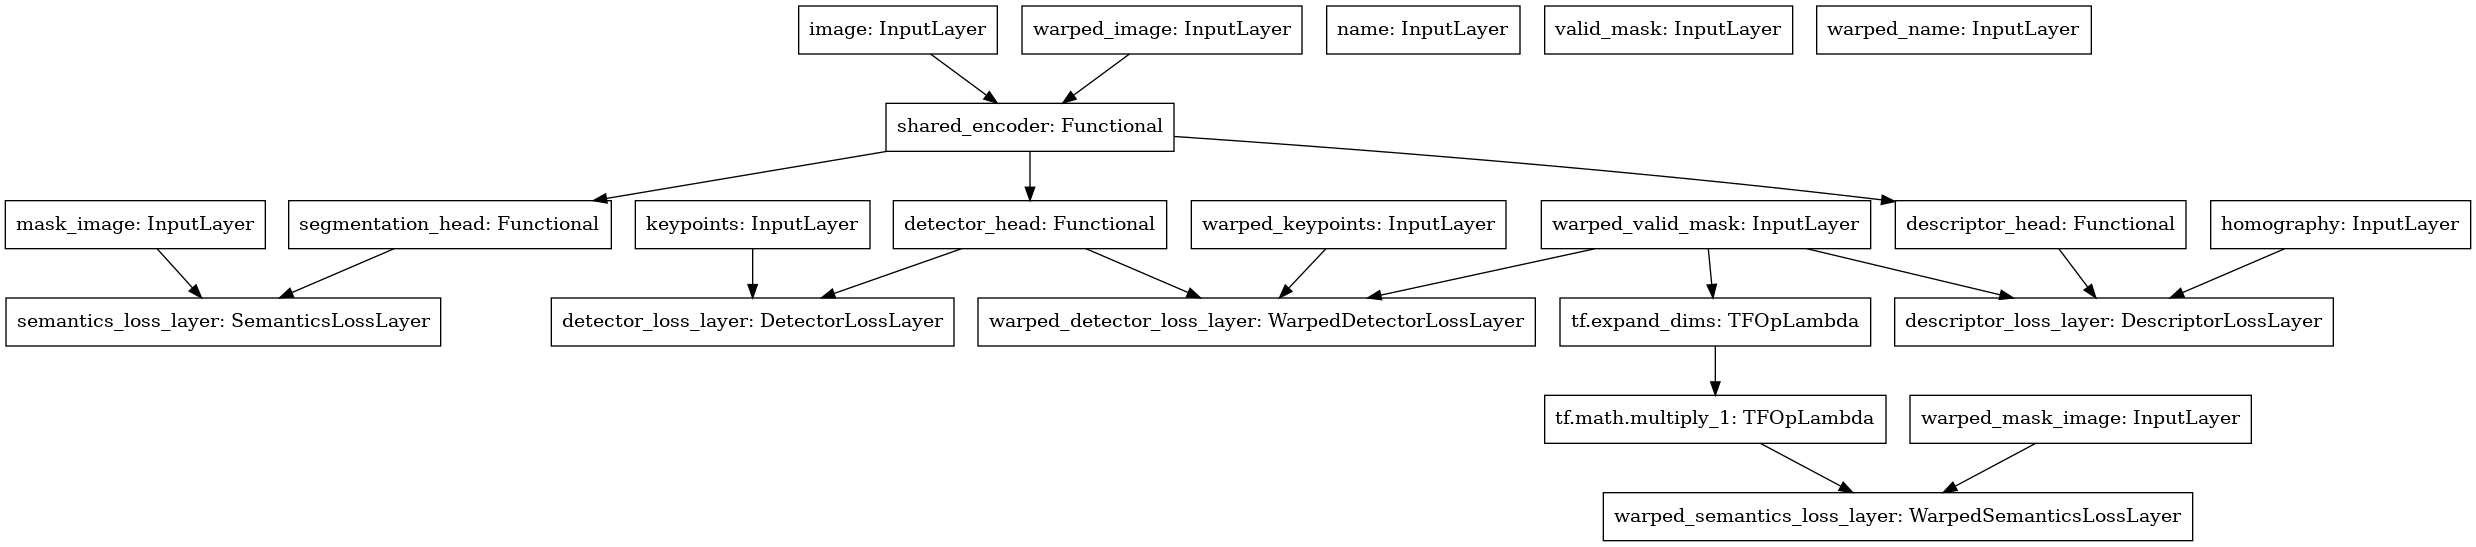

In [28]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [29]:
def detect_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def warped_detect_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def descript_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_loss1(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics1(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

model.compile(optimizer = keras.optimizers.Adam(learning_rate = model_config['learning_rate']),
              loss = [detect_loss, warped_detect_loss, descript_loss, 
                      dummy_loss, dummy_loss1],
             loss_weights=[1., 1., 1., 1., 1.])
#                        metrics = [_, _, _, tf.keras.metrics.BinaryAccuracy(),
#                                  tf.keras.metrics.BinaryAccuracy()])

In [30]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="/root/Internship-Valeo/Project/results/mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,)

TerminateOnNaN = tf.keras.callbacks.TerminateOnNaN()

In [31]:
# image_path_train = '/root/Internship-Valeo/Project/data/COCO/anntrain2014'
# point_path_train = '/root/Internship-Valeo/Project/data/COCO/magic_point-coco-export/pointstrain2014'
# # homography_path_train = '/root/Internship-Valeo/Project/data/COCO/homographies_train'
# seg_mask_path_train = '/root/Internship-Valeo/Project/data/COCO/masktrain2014'
# # warped_image_path_train = '/root/Internship-Valeo/Project/data/COCO/warptrain2014'
# # warped_point_path_train = '/root/Internship-Valeo/Project/data/COCO/warped_pointstrain2014'
# # warped_seg_mask_path_train = '/root/Internship-Valeo/Project/data/COCO/warp_mask_train2014'

In [32]:
# train_gen = DataGen(image_path = image_path_train, point_path = point_path_train, 
#                    #homography_path = homography_path_train, 
#                     seg_mask_path = seg_mask_path_train, 
# #                    warped_image_path = warped_image_path_train, warped_point_path = warped_point_path_train, 
# #                    warped_seg_mask_path = warped_seg_mask_path_train, 
#                  image_size_x = 320, image_size_y = 240,
#                  is_training = True, batch_size = model_config['batch_size'])


# train_steps =  len(os.listdir(image_path_train))/model_config['batch_size']

In [33]:
# image_path_val = '/root/Internship-Valeo/Project/data/COCO/annval2014'
# point_path_val = '/root/Internship-Valeo/Project/data/COCO/magic_point-coco-export/pointsval2014'
# # homography_path_val = '/root/Internship-Valeo/Project/data/COCO/homographies_val'
# seg_mask_path_val = '/root/Internship-Valeo/Project/data/COCO/maskval2014'
# # warped_image_path_val = '/root/Internship-Valeo/Project/data/COCO/warpval2014'
# # warped_point_path_val = '/root/Internship-Valeo/Project/data/COCO/warped_pointsval2014'
# # warped_seg_mask_path_val = '/root/Internship-Valeo/Project/data/COCO/warp_mask_val2014'

In [34]:
# val_gen = DataGen(image_path = image_path_val, point_path = point_path_val, 
#                    #homography_path = homography_path_val, 
#                   seg_mask_path = seg_mask_path_val, 
# #                    warped_image_path = warped_image_path_val, warped_point_path = warped_point_path_val, 
# #                    warped_seg_mask_path = warped_seg_mask_path_val, 
#                  image_size_x = 320, image_size_y = 240,
#                  is_training = True, batch_size = model_config['batch_size'])

In [35]:
train_image_path = DATA_PATH + '/COCO/anntrain2014'
train_gen = train_gen.repeat()
train_gen = train_gen.batch(model_config['batch_size'])
val_gen = val_gen.take(config['validation_size'])
val_gen = val_gen.batch(model_config['eval_batch_size'])

In [ ]:
steps_per_epoch = len(os.listdir(train_image_path))//model_config['batch_size']
epochs = config1['train_iter']//steps_per_epoch
history = model.fit(x = train_gen, validation_data = val_gen, 
                    batch_size = model_config['batch_size'], 
                     steps_per_epoch = steps_per_epoch, epochs=epochs, 
                    callbacks=[model_checkpoint_callback, TerminateOnNaN, 
                        tensorboard_callback])

Epoch 1/13
  321/45174 [..............................] - ETA: 3:00:51 - loss: 10.4123 - detector_loss_layer_loss: 0.0000e+00 - warped_detector_loss_layer_loss: 0.0000e+00 - descriptor_loss_layer_loss: 0.0000e+00 - semantics_loss_layer_loss: 0.0000e+00 - warped_semantics_loss_layer_loss: 0.0000e+00 - detector_precision: 0.0047 - detector_recall: 0.0522 - warped_detector_precision: 0.0050 - warped_detector_recall: 0.0516 - binary_accuracy: 0.6172

In [ ]:
model.save('/root/Internship-Valeo/Project/results/checkpoint-mtl-coco-190422')

In [36]:
x = iter(train_gen).next()

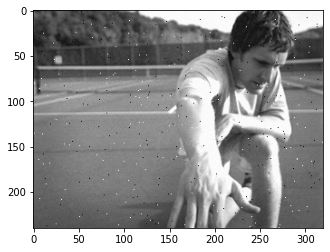

In [37]:
plt.imshow(x['image'][0], cmap = 'gray')

In [38]:
x['name']

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'COCO_train2014_000000533809'], dtype=object)>

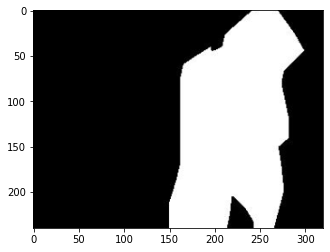

In [39]:
plt.imshow(x['mask_image'][0], cmap = 'gray')

In [42]:
np.max(x['warped']['mask_image'][0])

1.0

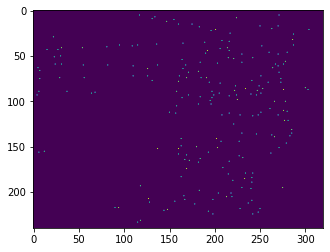

In [43]:
plt.imshow(x['keypoints'][0])

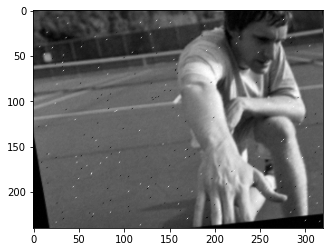

In [44]:
plt.imshow(x['warped']['image'][0], cmap = 'gray')

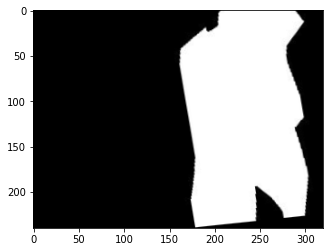

In [45]:
plt.imshow(x['warped']['mask_image'][0], cmap = 'gray')

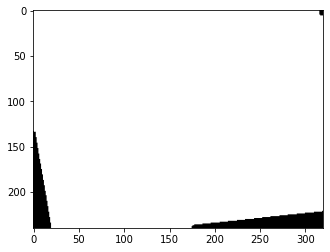

In [46]:
plt.imshow(x['warped']['valid_mask'][0], cmap = 'gray')

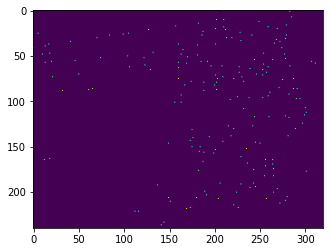

In [47]:
plt.imshow(x['warped']['keypoints'][0])

In [48]:
x['warped']['homography'][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 9.2617643e-01, -1.5872931e-01,  2.1065723e+01,  8.7331399e-02,
        9.0470809e-01,  6.3085284e+00, -3.5506069e-05, -7.4404474e-09],
      dtype=float32)>

In [49]:
result = model.predict(x)

In [50]:
result

[4.1728057861328125,
 4.172739028930664,
 0.9725381135940552,
 0.9064129590988159,
 0.9943294525146484]